# zz

In [1]:
zs = 0.53

sehirler=["Adana", "Adıyaman", "Afyon", "Ağrı", "Amasya", "Ankara", "Antalya", "Artvin", "Aydın", "Balıkesir", 
          "Bilecik", "Bingöl", "Bitlis", "Bolu", "Burdur", "Bursa", "Çanakkale", "Çankırı", "Çorum", "Denizli", 
          "Diyarbakır", "Edirne", "Elazığ", "Erzincan", "Erzurum", "Eskişehir", "Gaziantep", "Giresun", "Gümüşhane", 
          "Hakkari", "Hatay", "Isparta", "Mersin", "İstanbul", "İzmir", "Kars", "Kastamonu", "Kayseri", "Kırklareli", 
          "Kırşehir", "Kocaeli", "Konya", "Kütahya", "Malatya", "Manisa", "Kahramanmaraş", "Mardin", "Muğla", "Muş", 
          "Nevşehir", "Niğde", "Ordu", "Rize", "Sakarya", "Samsun", "Siirt", "Sinop", "Sivas", "Tekirdağ", "Tokat", 
          "Trabzon", "Tunceli", "Şanlıurfa", "Uşak", "Van", "Yozgat", "Zonguldak", "Aksaray", "Bayburt", "Karaman", 
          "Kırıkkale", "Batman", "Şırnak", "Bartın", "Ardahan", "Iğdır", "Yalova", "Karabük", "Kilis", "Osmaniye", "Düzce"]

for i in range(len(sehirler)):
    sehirler[i] = sehirler[i].lower()
    sehirler[i] = sehirler[i].replace('i̇','i')

# Import libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import mode

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### accuracy_calculate function

In [3]:
def accuracy_calculate(actual_values, predicted_values):

  comparison = abs(np.round(predicted_values) - actual_values)
  accuracy = 1- ((len(comparison[comparison>=(0+1)])) / len(actual_values))

  return accuracy

#### mean_iou_calculator function

In [4]:
def mean_iou_calculator(actual_values, predicted_values, time):
  confusion_array = confusion_matrix(actual_values, predicted_values)
  individual_ious = []
  for i in range(len(confusion_array)):
    individual_iou = confusion_array[i][i] / (sum(confusion_array[i]))
    individual_ious.append(individual_iou)
  mean_iou = sum(individual_ious)/len(individual_ious)
  results = pd.DataFrame()  
  featue_y_values = sorted(data[time].unique())
  for i in range(len(individual_ious)):
    results.insert(0, 'iou_(' + str(featue_y_values[i])  +')', [individual_ious[i]], True)
  results = results[results.columns[::-1]]
  results.insert(0, 'mean_iou', mean_iou, True)
  return results

# Start

In [5]:
data = pd.read_csv('gulle.csv', sep=';', encoding = "utf8")
data.columns = ['product', 'amount', 'company', 'town', 'type', 'order date', 'delivery date', 'time'] #Rearannge the dataframe as the old one

data2 = data.drop('delivery date', axis = 1)
data2["order day"] = ''
data2["order month"] = ''
data2["week day"] = ''


# Remove 'order date' and add 'order day', 'order month' and 'week day' features
for i in range(len(data2)):
  data2.at[i, 'order day'] = data2['order date'][i].split()[0]
  data2.at[i, 'order month'] = data2['order date'][i].split()[1]
  data2.at[i, 'week day'] = data2['order date'][i].split()[-1]
data2 = data2.drop('order date', axis = 1)
data2['week day'] = data2['week day'].str.replace('Pazartesi','pts')
data2['week day'] = data2['week day'].str.replace('Salı','sal')
data2['week day'] = data2['week day'].str.replace('Çarşamba','çrş')
data2['week day'] = data2['week day'].str.replace('Perşembe','prş')
data2['week day'] = data2['week day'].str.replace('Cumartesi','cts')
data2['week day'] = data2['week day'].str.replace('Cuma','cum')
data2['week day'] = data2['week day'].str.replace('Pazar','paz')

# data2 = data2[data2["week day"].str.contains("Pazar") == False]

# Rearranging Dataframe
data2 = data2[['product', 'company', 'amount', 'town', 'type', 'order day', 'week day', 'order month', 'time']]
data2['town'] = data2['town'].str.lower()
data2['town'] = data2['town'].str.replace('i̇','i')
data2['town'] = data2['town'].str.replace('.','missing')
data2['town'] = data2['town'].str.replace(' tekirdağ','tekirdağ')
data2['town'] = data2['town'].str.replace('küçükçekmece','istanbul')
data2['town'] = data2['town'].str.replace('çorlu','tekirdağ')
data2['town'] = data2['town'].str.replace('bandirma','balıkesir')

#data2 = data2.drop('town',axis = 1).reset_index(drop=True)
data2 = data2.drop('order day',axis = 1).reset_index(drop=True)
data2 = data2.drop('order month',axis = 1).reset_index(drop=True)
data2 = data2.fillna("missing")
#data2 = data2[data2["town"].str.contains("missing") == False]

data_clean = data2.copy()
drop_df = data2.copy()
drop_index_list = []

data2

,product,company,amount,town,type,week day,time
0,K477,T-029,1,bursa,1,pts,2
1,K669,T-016,1,istanbul,1,cum,4
2,K75,T-018,1,istanbul,1,çrş,1
3,K669,T-016,1,istanbul,1,pts,1
4,K513,T-034,1,istanbul,1,sal,1
...,...,...,...,...,...,...,...
1111,K522,T-034,960,istanbul,1,sal,1
1112,K730,T-060,960,tekirdağ,1,pts,4
1113,K788,T-060,960,tekirdağ,1,pts,4
1114,K1117,T-0211,960,kocaeli,1,sal,1


# Get list of abroad companies and products that are supplied from abroad

In [6]:
abr = [item for item in data2["town"].unique() if item not in sehirler]
abr_str = ""

for i in range (len(abr)):
    abr_str = abr_str + "|" + abr[i]
abr_str = abr_str[1:]

if len(abr) != 0:
    data3 = data2[data2["town"].astype('str').str.contains(abr_str) == True]
    abr_comp_list = data3["company"].unique()
    abr_prod_list = data3["product"].unique()
    print("abroad company list: ",abr_comp_list)
    print("abroad product list: ",abr_prod_list)
else:
    print("no abroad company")


abroad company list:  ['T-0142' 'MZ-401']
abroad product list:  ['K730' 'K390' 'MRL313' 'K1046' 'K143' 'K664' 'K9' 'K389' 'K256' 'K395']


# Remove insufficient data

In [7]:
def remove_insuff(df, ft):
    print("removing insufficient data for ", ft, "...")
    fst_len = len(df)
    x = df[ft].value_counts() < 5 
    df2 = x.to_frame().reset_index()
    df2.columns = [ft, 'booly']
    df2.drop(df2[df2.booly == False].index, inplace=True)
    drop_list = df2[ft].tolist()
    drop_indices=[]

    if len(drop_list) != 0:
        for i in df.index:
            for j in range(len(drop_list)):
                if (drop_list[j] == df.at[i, ft]):
                    drop_indices = drop_indices + [i]
        df.drop(drop_indices, inplace=True)
        
    else:
        drop_indices = []
                        
    lst_len = len(df)
    rem = fst_len - lst_len      # number of removed data
    per = (rem / fst_len) * 100  # percentage of removed data

    print("total number of removed data: ", rem)
    print("persentage of removed data: ", round(per, 2), "%")
    return df, drop_indices

In [8]:
data2, drop_indices = remove_insuff(data2, "company")
drop_index_list = drop_index_list + drop_indices

data2, drop_indices = remove_insuff(data2, "product")
drop_index_list = drop_index_list + drop_indices

removing insufficient data for  company ...
total number of removed data:  32
persentage of removed data:  2.87 %
removing insufficient data for  product ...
total number of removed data:  169
persentage of removed data:  15.59 %


In [9]:
data_suf = data2.copy()

n_prod = data_suf["product"].nunique()
prod_list = data_suf["product"].unique()
n_comp = data_suf["company"].nunique()
comp_list = data_suf["company"].unique()

# One - Hot - Encoding

In [10]:
def one_hot(df, ft):      ### ft = "company", "product", "week day" etc.
    print("one hot encoding ", ft, "...")
    dum = pd.get_dummies(df[ft])
    df = df.drop(ft, axis = 1)
    df = df.join(dum)
    print(ft, "encoded.")
    return df

In [11]:
data2  = one_hot(data2, "week day")
data2  = one_hot(data2, "company")
data2  = one_hot(data2, "product")
data2

one hot encoding  week day ...
week day encoded.
one hot encoding  company ...
company encoded.
one hot encoding  product ...
product encoded.


,amount,town,type,time,cts,cum,prş,pts,sal,çrş,...,K669,K688,K700,K730,K744,K746,K765,K788,K9,K980
0,1,bursa,1,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,kocaeli,1,3,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6,1,kocaeli,1,3,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
7,1,kocaeli,1,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
8,1,kocaeli,1,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,960,missing,1,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1111,960,istanbul,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1112,960,tekirdağ,1,4,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1113,960,tekirdağ,1,4,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


# Train - Test Split

In [12]:
from sklearn.model_selection import train_test_split

df4 = data2
x_train, x_val = train_test_split(df4, test_size = 0.2, random_state = 40)

# Clean noise

In [13]:
### değerler clean_noise fonksiyonunda kullanılıyor !!

# n_prod = data2["product"].nunique()
# prod_list = data2["product"].unique()
# n_comp = data2["company"].nunique()
# comp_list = data2["company"].unique()

In [14]:
def clean_noise(df): # df = x_train/x_test
    in_len = len(df)
    zs = 0.53
        
    print("Cleaning noise ... ")
    
    index_drop_list = []
    for prod in prod_list:

        df_max_scaled = df[df[prod] == 1].copy()

        for comp in comp_list:
            df_max_scaled2 = df_max_scaled[df_max_scaled[comp] == 1].copy()

            if len(df_max_scaled2) > 1:
                
                max_min_t = df_max_scaled2["time"].max() - df_max_scaled2["time"].min()
                max_min_a = df_max_scaled2["amount"].max() - df_max_scaled2["amount"].min()
                
                if (max_min_a != 0) and (max_min_t != 0):
                    df_max_scaled2["time"] = (df_max_scaled2["time"] - df_max_scaled2["time"].min()) / max_min_t
                    t_sc = df_max_scaled2[["time"]]
                    df_zscore_t = (t_sc - t_sc.mean())/t_sc.std()
                    dfz_t = abs(df_zscore_t) > zs

                    df_max_scaled2["amount"] = (df_max_scaled2["amount"] - df_max_scaled2["amount"].min()) / max_min_a
                    amo_sc = df_max_scaled2["amount"]
                    df_zscore_a = (amo_sc - amo_sc.mean())/amo_sc.std()
                    dfz_a = abs(df_zscore_a) > zs

                    df1 = dfz_t["time"] & dfz_a 
                    df2 = (df_zscore_t["time"] * df_zscore_a) < 0 
                    dfz = df1 & df2 

                    index_drop_list = index_drop_list + [*filter(dfz.get, dfz.index)]

    index_drop_list = sorted(list(set(index_drop_list)))
    df.drop(index_drop_list, axis=0, inplace=True)
    rem = len(index_drop_list)
    f_len = len(df)
    n_del = in_len - f_len
    per = (n_del / in_len) * 100
    
    print("deleted indices: ",index_drop_list)
    print("total number of removed data: ", n_del)
    print("persentage of removed data: ", round(per, 2), "%")
    
    return df, index_drop_list

In [15]:
pd.options.mode.chained_assignment = None

x_train, train_drop_list = clean_noise(x_train)
drop_index_list = drop_index_list + train_drop_list

x_val, val_drop_list = clean_noise(x_val)
drop_index_list = drop_index_list + val_drop_list

Cleaning noise ... 
deleted indices:  [125, 133, 139, 163, 194, 196, 218, 228, 247, 250, 254, 255, 306, 310, 311, 317, 356, 358, 361, 372, 376, 377, 462, 475, 477, 492, 494, 508, 532, 547, 549, 581, 617, 639, 675, 684, 688, 689, 701, 703, 707, 708, 717, 720, 737, 745, 782, 787, 818, 834, 854, 871, 897, 902, 908, 939, 948, 949, 953, 955, 956, 957, 967, 972, 982, 985, 991, 1010, 1011, 1016, 1018, 1021, 1025, 1026, 1031, 1033, 1034, 1037, 1073, 1076, 1088, 1092, 1098, 1099, 1100, 1107, 1108, 1109, 1110, 1115]
total number of removed data:  90
persentage of removed data:  12.3 %
Cleaning noise ... 
deleted indices:  [185, 197, 212, 433, 511, 541, 564, 578, 663, 673, 712, 744, 800, 807, 814, 945, 1012, 1014, 1017, 1024, 1075, 1089, 1096, 1101]
total number of removed data:  24
persentage of removed data:  13.11 %


In [16]:
data2.drop(train_drop_list, axis=0, inplace=True)
data2.drop(val_drop_list, axis=0, inplace=True)

# Drop_df

In [17]:
drop_index_list = sorted(list(set(drop_index_list)))
drop_df = drop_df.loc[drop_index_list]
drop_df

,product,company,amount,town,type,week day,time
1,K669,T-016,1,istanbul,1,cum,4
2,K75,T-018,1,istanbul,1,çrş,1
3,K669,T-016,1,istanbul,1,pts,1
4,K513,T-034,1,istanbul,1,sal,1
9,K637,T-015,1,istanbul,1,cum,7
...,...,...,...,...,...,...,...
1108,K788,T-060,960,tekirdağ,1,sal,1
1109,K788,T-060,960,tekirdağ,1,prş,1
1110,K730,T-0142,960,missing,1,prş,1
1114,K1117,T-0211,960,kocaeli,1,sal,1


In [18]:
data_clean.drop(drop_df.index.to_list(), axis=0, inplace=True)
data_clean

,product,company,amount,town,type,week day,time
0,K477,T-029,1,bursa,1,pts,2
5,K669,T-0211,1,kocaeli,1,cum,3
6,K669,T-0211,1,kocaeli,1,pts,3
7,K669,T-0211,1,kocaeli,1,pts,1
8,K669,T-0211,1,kocaeli,1,prş,1
...,...,...,...,...,...,...,...
1103,K669,T-0211,920,kocaeli,1,sal,1
1104,K788,T-060,940,tekirdağ,1,sal,3
1111,K522,T-034,960,istanbul,1,sal,1
1112,K730,T-060,960,tekirdağ,1,pts,4


# Map time

In [19]:
def map_time(df):
    for i in df.index:
        if ((df.at[i, "time"]<=4) and (df.at[i, "time"]>=3)):
            df.at[i, "time"] = 3
        elif ((df.at[i, "time"]<=7) and (df.at[i, "time"]>=5)):
            df.at[i, "time"] = 4
        elif ((df.at[i, "time"]<=14) and (df.at[i, "time"]>=8)):
            df.at[i, "time"] = 5
        elif ((df.at[i, "time"]<=30) and (df.at[i, "time"]>=15)):
            df.at[i, "time"] = 6
        elif (df.at[i, "time"]>30):
            df.at[i, "time"] = 7
    return df
            
#         elif (df.at[i, "time"]==1):
#             df.at[i, "time"] = "1"    
#         elif (df.at[i, "time"]==2):
#             df.at[i, "time"] = "2"

In [20]:
x_train = map_time(x_train)
x_val = map_time(x_val)

In [21]:
def categorize(df):
    ls = df.columns.to_list()
    ls.remove("amount")
    df[ls] = df[ls].astype('category')
#     df['time'] = df['time'].cat.rename_categories({1:"1 gün", 2:"2 gün", 3:"3-4 gün", 4:"5-7 gün", 5:"8-14 gün", 6:"15-30 gün", 7:"+30 gün"})
    return df

In [22]:
# x_train = categorize(x_train)
# x_val = categorize(x_val)

# Drop town column

In [23]:
x_train = x_train.drop('town',axis = 1).reset_index(drop=True)
x_val = x_val.drop('town',axis = 1).reset_index(drop=True)

In [24]:
x_train

,amount,type,time,cts,cum,prş,pts,sal,çrş,T-0108,...,K669,K688,K700,K730,K744,K746,K765,K788,K9,K980
0,100,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,200,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,100,1,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,900,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,4,1,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
638,1,1,4,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
639,1,1,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
640,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Construct y_train & y_val

In [25]:
y_train = x_train["time"].copy().to_frame()
x_train.drop("time", axis=1, inplace=True)

y_val = x_val["time"].copy().to_frame()
x_val.drop("time", axis=1, inplace=True)

y_train = y_train.squeeze(axis=1)
y_val = y_val.squeeze(axis=1)

y_val = y_val.to_list()

In [26]:
# y_train = x_train[["time"]].copy()
# y_val = x_val[["time"]].copy()

# x_train.drop("time", axis=1, inplace=True)
# x_val.drop("time", axis=1, inplace=True)

# y_val = one_hot(y_val, "time")
# #y_val = y_val.to_frame()

# y_train = one_hot(y_train, "time")
# #y_train = y_train.to_frame()



# Normalize amount

In [27]:
xt_min = x_train["amount"].min()
xt_max = x_train["amount"].max()

x_train["amount"] = (x_train["amount"] - xt_min) / (xt_max - xt_min)
x_val["amount"] = (x_val["amount"] - xt_min) / (xt_max - xt_min)

# Create a df_empty with the same columns of x_train 

In [28]:
df_empty = x_train[0:0]
df_empty

,amount,type,cts,cum,prş,pts,sal,çrş,T-0108,T-0127,...,K669,K688,K700,K730,K744,K746,K765,K788,K9,K980


# PCA

In [29]:
def do_pca(x_train, x_val):
    from sklearn.decomposition import PCA
    xl = len(x_train.columns)
    pca = PCA(.95)
    pca.fit(x_train)
    print("number of features dropped from ", xl, " to ", pca.n_components_) 
    #print("variance ratio: ", pca.explained_variance_ratio_) 

    x_train = pca.transform(x_train)
    x_val = pca.transform(x_val)
    return pca, x_train, x_val

# SMOTE

#### SMOTENC
##### before pca for sure (there are categorical fts)

In [30]:
def get_categorical_fts(df):
    fts = list(df.columns)
    fts.remove('amount')
    return fts

In [31]:
# from imblearn.over_sampling import SMOTENC
# from collections import Counter

# print(f'Original dataset shape {x_train.shape}')
# print(f'Original dataset samples per class {Counter(y_train)}')

# # categorical features
# fts = list(range(1, ((x_train.shape[1]))))

# sm = SMOTENC(random_state=42, categorical_features=fts, sampling_strategy='all', k_neighbors=4, n_jobs=-1)
# X_res, y_res = sm.fit_resample(x_train, y_train)
# print(f'Resampled dataset samples per class {Counter(y_res)}')
# print(f'Resampled dataset shape {X_res.shape}')
# x_train, y_train = X_res, y_res

#### SMOTEENN
##### after pca?

In [32]:
pca, x_train, x_val = do_pca(x_train, x_val)

number of features dropped from  84  to  43


In [33]:
# from imblearn.combine import SMOTEENN
# from imblearn.over_sampling import SMOTE 
# from imblearn.under_sampling import EditedNearestNeighbours 
# from collections import Counter
# print('Original dataset shape %s' % Counter(y_train))
# print(f'Original dataset samples per class {Counter(y_train)}')

# sm_obj = SMOTE(random_state=42, sampling_strategy='all', k_neighbors=4, n_jobs=-1)
# enn_obj = EditedNearestNeighbours(sampling_strategy='all', n_neighbors=3, kind_sel='mode', n_jobs=-1)
# sme = SMOTEENN(random_state=42, smote=sm_obj, enn=enn_obj, sampling_strategy='all', n_jobs=-1)
# X_res, y_res = sme.fit_resample(x_train, y_train)
# print('Resampled dataset shape %s' % Counter(y_res))
# print(f'Resampled dataset shape {X_res.shape}')
# x_train, y_train = X_res, y_res

# Results

### Train

In [34]:
random_state = 42
kernel = 1.0 * RBF(1.0)

Logistic_Regression = LogisticRegression(random_state= random_state, multi_class='multinomial', max_iter = 1000).fit(x_train, y_train.astype('int'))
#linearReg = LinearRegression().fit(x_train, y_train.astype('int'))
rndmForest = RandomForestClassifier(n_estimators=1000, class_weight="balanced", n_jobs=-1, min_samples_leaf=3, max_depth=5,
                                    random_state=random_state).fit(x_train, y_train.astype('int'))
                                                                   
#MLP = MLPClassifier(random_state=1, max_iter=5000).fit(x_train, y_train.astype('int'))

#Finding k value fom max accuracy
k_values=[]
for k in range(1, 51):
    KNeighbors = KNeighborsClassifier(n_neighbors=k, weights='distance').fit(x_train, y_train.astype('int'))
    KNeighbors_predictions = KNeighbors.predict(x_val)
    k_values.append(balanced_accuracy_score(y_val, KNeighbors_predictions))
k_max = k_values.index(max(k_values)) + 1

KNeighbors = KNeighborsClassifier(n_neighbors=k_max).fit(x_train, y_train.astype('int'))
CSupportVector = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(x_train, y_train.astype('int'))
DecisionTtree = DecisionTreeClassifier(random_state=0).fit(x_train, y_train.astype('int'))
# GaussianProcess = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(x_train, y_train.astype('int'))
# AdaBoost = AdaBoostClassifier(n_estimators=1000, random_state=0).fit(x_train, y_train.astype('int'))
# GaussianNaiveBayes = GaussianNB().fit(x_train, y_train.astype('int'))
# QuadraticDiscriminantAnalysis = QuadraticDiscriminantAnalysis().fit(x_train, y_train.astype('int'))


LogisticRegression_predictions = Logistic_Regression.predict(x_train)
#linearReg_predictions = linearReg.predict(x_val)
rndmForest_predictions = rndmForest.predict(x_train)
#MLP_predictions = MLP.predict(x_val)
KNeighbors_predictions = KNeighbors.predict(x_train)
CSupportVector_predictions = CSupportVector.predict(x_train)
DecisionTtree_predictions = DecisionTtree.predict(x_train)
# GaussianProcess_predictions = GaussianProcess.predict(x_val)
# AdaBoost_predictions = AdaBoost.predict(x_val)
# GaussianNaiveBayes_predictions = GaussianNaiveBayes.predict(x_val)
# QuadraticDiscriminantAnalysis_predictions = QuadraticDiscriminantAnalysis.predict(x_val)


print('Accuracy of LogisticRegression classifier: ', accuracy_calculate(y_train, LogisticRegression_predictions))
#print('Accuracy of LinearRegression classifier: ', accuracy_calculate(y_val, linearReg_predictions))
print('Accuracy of RandomForest classifier: ', accuracy_calculate(y_train, rndmForest_predictions))
#print('Accuracy of Multi-layer Perceptron classifier: ', accuracy_calculate(y_val, MLP_predictions))
print('Accuracy of KNeighbors classifier: ', accuracy_calculate(y_train, KNeighbors_predictions))
print('Accuracy of CSupportVector classifier: ', accuracy_calculate(y_train, CSupportVector_predictions))
print('Accuracy of DecisionTtree classifier: ', accuracy_calculate(y_train, DecisionTtree_predictions))
#print('Accuracy of GaussianProcess classifier: ', accuracy_calculate(y_val, GaussianProcess_predictions))
#print('Accuracy of AdaBoost classifier: ', accuracy_calculate(y_val, AdaBoost_predictions))
#print('Accuracy of GaussianNaiveBayes classifier: ', accuracy_calculate(y_val, GaussianNaiveBayes_predictions))
#print('Accuracy of QuadraticDiscriminantAnalysis classifier: ', accuracy_calculate(y_val, QuadraticDiscriminantAnalysis_predictions))

Accuracy of LogisticRegression classifier:  0.6900311526479751
Accuracy of RandomForest classifier:  0.6588785046728972
Accuracy of KNeighbors classifier:  0.6292834890965733
Accuracy of CSupportVector classifier:  0.6838006230529595
Accuracy of DecisionTtree classifier:  0.8442367601246106


#### Balanced Accuracy / train

In [35]:
print('Balanced_Accuracy of LogisticRegression classifier: ', balanced_accuracy_score(y_train, LogisticRegression_predictions))
print('Balanced_Accuracy of RandomForest classifier: ', balanced_accuracy_score(y_train, rndmForest_predictions))
print('Balanced_Accuracy of KNeighbors classifier: ', balanced_accuracy_score(y_train, KNeighbors_predictions))
print('Balanced_Accuracy of CSupportVector classifier: ', balanced_accuracy_score(y_train, CSupportVector_predictions))
print('Balanced_Accuracy of DecisionTtree classifier: ', balanced_accuracy_score(y_train, DecisionTtree_predictions))

Balanced_Accuracy of LogisticRegression classifier:  0.3083431150450308
Balanced_Accuracy of RandomForest classifier:  0.8167834851913132
Balanced_Accuracy of KNeighbors classifier:  0.2232887985269185
Balanced_Accuracy of CSupportVector classifier:  0.2959322340780148
Balanced_Accuracy of DecisionTtree classifier:  0.6775764941085197


In [36]:
### DENİYOZ İŞTE #################################################################

In [37]:
# DecisionTtree = DecisionTreeClassifier(random_state=0, criterion='gini', min_samples_leaf=3, max_depth=20).fit(x_train, y_train.astype('int'))
# DecisionTtree_predictions = DecisionTtree.predict(x_train)
# print('Accuracy of DecisionTtree_predictions : ', accuracy_calculate(y_train, DecisionTtree_predictions))
# print('Balanced_Accuracy of DecisionTtree_predictions : ', balanced_accuracy_score(y_train, DecisionTtree_predictions))

# DecisionTtree_predictions = DecisionTtree.predict(x_val)
# print('Accuracy of DecisionTtree_predictions : ', accuracy_calculate(y_val, DecisionTtree_predictions))
# print('Balanced_Accuracy of DecisionTtree_predictions : ', balanced_accuracy_score(y_val, DecisionTtree_predictions))



In [38]:
# Logistic_Regression = LogisticRegression(class_weight="balanced", multi_class="ovr", random_state= random_state, max_iter = 1000).fit(x_train, y_train.astype('int'))
# LogisticRegression_predictions = Logistic_Regression.predict(x_train)
# print('Accuracy of LogisticRegression classifier: ', accuracy_calculate(y_train, LogisticRegression_predictions))
# print('Balanced_Accuracy of LogisticRegression classifier: ', balanced_accuracy_score(y_train, LogisticRegression_predictions))

# LogisticRegression_predictions = Logistic_Regression.predict(x_val)
# print('Accuracy of LogisticRegression classifier: ', accuracy_calculate(y_val, LogisticRegression_predictions))
# print('Balanced_Accuracy of LogisticRegression classifier: ', balanced_accuracy_score(y_val, LogisticRegression_predictions))


In [39]:
# svm = SGDClassifier(loss='log',class_weight="balanced", max_iter=2000).fit(x_train, y_train)
# predictions = svm.predict(x_val)
# print("accuracy: ",accuracy_score(predictions, y_val))
# print("accuracy: ",balanced_accuracy_score(predictions, y_val))

In [40]:
###############################################################

#### LogisticRegression / train

balanced_accuracy:  0.3083431150450308
accuracy:  0.6900311526479751
precision:  0.6746429266020502
recall:  0.6900311526479751
f1 score:  0.644985910984628


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


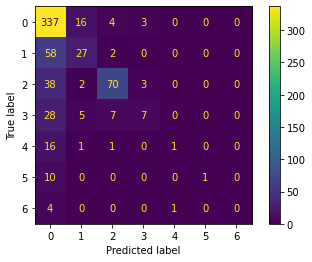

In [41]:
print("balanced_accuracy: ",balanced_accuracy_score(y_train, LogisticRegression_predictions))
print("accuracy: ",accuracy_score(y_train, LogisticRegression_predictions))
print("precision: ",precision_score(y_train, LogisticRegression_predictions,average='weighted'))
print("recall: ",recall_score(y_train, LogisticRegression_predictions,average='weighted'))
print("f1 score: ",f1_score(y_train, LogisticRegression_predictions,average='weighted'))

cm = confusion_matrix(y_train, LogisticRegression_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [42]:
mean_iou_calculator(y_train, LogisticRegression_predictions, "time")

,mean_iou,iou_(1),iou_(2),iou_(3),iou_(4),iou_(5),iou_(6),iou_(7)
0,0.308343,0.936111,0.310345,0.619469,0.148936,0.052632,0.090909,0.0


#### RandomForestClassifier / train

balanced_accuracy:  0.8167834851913132
accuracy:  0.6588785046728972
precision:  0.7818240669016822
recall:  0.6588785046728972
f1 score:  0.6801967023894225


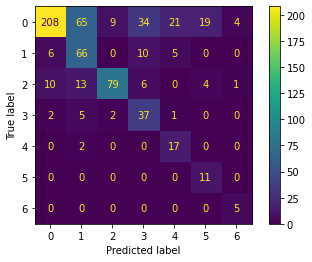

In [43]:
print("balanced_accuracy: ",balanced_accuracy_score(y_train, rndmForest_predictions))
print("accuracy: ",accuracy_score(y_train, rndmForest_predictions))
print("precision: ",precision_score(y_train, rndmForest_predictions,average='weighted'))
print("recall: ",recall_score(y_train, rndmForest_predictions,average='weighted'))
print("f1 score: ",f1_score(y_train, rndmForest_predictions,average='weighted'))

cm = confusion_matrix(y_train, rndmForest_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [44]:
mean_iou_calculator(y_train, rndmForest_predictions, "time")

,mean_iou,iou_(1),iou_(2),iou_(3),iou_(4),iou_(5),iou_(6),iou_(7)
0,0.816783,0.577778,0.758621,0.699115,0.787234,0.894737,1.0,1.0


#### KNeighborsClassifier  / train

balanced_accuracy:  0.2232887985269185
accuracy:  0.6292834890965732
precision:  0.6043678303813883
recall:  0.6292834890965732
f1 score:  0.5438430596997673


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


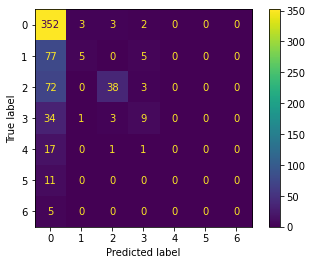

In [45]:
print("balanced_accuracy: ",balanced_accuracy_score(y_train, KNeighbors_predictions))
print("accuracy: ",accuracy_score(y_train, KNeighbors_predictions))
print("precision: ",precision_score(y_train, KNeighbors_predictions,average='weighted'))
print("recall: ",recall_score(y_train, KNeighbors_predictions,average='weighted'))
print("f1 score: ",f1_score(y_train, KNeighbors_predictions,average='weighted'))

cm = confusion_matrix(y_train, KNeighbors_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [46]:
mean_iou_calculator(y_train, rndmForest_predictions, "time")

,mean_iou,iou_(1),iou_(2),iou_(3),iou_(4),iou_(5),iou_(6),iou_(7)
0,0.816783,0.577778,0.758621,0.699115,0.787234,0.894737,1.0,1.0


#### CSupportVector  / train

balanced_accuracy:  0.2959322340780148
accuracy:  0.6838006230529595
precision:  0.6830525362642813
recall:  0.6838006230529595
f1 score:  0.6211062984886025


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


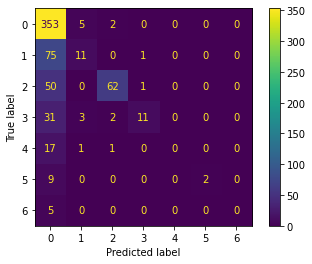

In [47]:
print("balanced_accuracy: ",balanced_accuracy_score(y_train, CSupportVector_predictions))
print("accuracy: ",accuracy_score(y_train, CSupportVector_predictions))
print("precision: ",precision_score(y_train, CSupportVector_predictions,average='weighted'))
print("recall: ",recall_score(y_train, CSupportVector_predictions,average='weighted'))
print("f1 score: ",f1_score(y_train, CSupportVector_predictions,average='weighted'))

cm = confusion_matrix(y_train, CSupportVector_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [48]:
mean_iou_calculator(y_train, CSupportVector_predictions, "time")

,mean_iou,iou_(1),iou_(2),iou_(3),iou_(4),iou_(5),iou_(6),iou_(7)
0,0.295932,0.980556,0.126437,0.548673,0.234043,0.0,0.181818,0.0


## Test

In [49]:
# # random_state = 42
# # kernel = 1.0 * RBF(1.0)

# # Logistic_Regression = LogisticRegression(random_state= random_state, max_iter = 1000).fit(x_train, y_train.astype('int'))
# # #linearReg = LinearRegression().fit(x_train, y_train.astype('int'))
# # rndmForest = RandomForestClassifier(n_estimators=1000, class_weight="balanced", n_jobs=-1, min_samples_leaf=3, max_depth=5,
# #                                     random_state=random_state).fit(x_train, y_train.astype('int'))
                                                                   
# # #MLP = MLPClassifier(random_state=1, max_iter=5000).fit(x_train, y_train.astype('int'))

# # #Finding k value fom max accuracy
# # k_values=[]
# # for k in range(1, 51):
# #     KNeighbors = KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train.astype('int'))
# #     KNeighbors_predictions = KNeighbors.predict(x_val)
# #     k_values.append(accuracy_calculate(y_val, KNeighbors_predictions))

# # k_max = k_values.index(max(k_values)) + 1
# KNeighbors = KNeighborsClassifier(n_neighbors=k_max).fit(x_train, y_train.astype('int'))
# CSupportVector = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(x_train, y_train.astype('int'))
# DecisionTtree = DecisionTreeClassifier(random_state=0).fit(x_train, y_train.astype('int'))
# # GaussianProcess = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(x_train, y_train.astype('int'))
# # AdaBoost = AdaBoostClassifier(n_estimators=1000, random_state=0).fit(x_train, y_train.astype('int'))
# # GaussianNaiveBayes = GaussianNB().fit(x_train, y_train.astype('int'))
# # QuadraticDiscriminantAnalysis = QuadraticDiscriminantAnalysis().fit(x_train, y_train.astype('int'))


LogisticRegression_predictions = Logistic_Regression.predict(x_val)
#linearReg_predictions = linearReg.predict(x_val)
rndmForest_predictions = rndmForest.predict(x_val)
#MLP_predictions = MLP.predict(x_val)
KNeighbors_predictions = KNeighbors.predict(x_val)
CSupportVector_predictions = CSupportVector.predict(x_val)
DecisionTtree_predictions = DecisionTtree.predict(x_val)
# GaussianProcess_predictions = GaussianProcess.predict(x_val)
# AdaBoost_predictions = AdaBoost.predict(x_val)
# GaussianNaiveBayes_predictions = GaussianNaiveBayes.predict(x_val)
# QuadraticDiscriminantAnalysis_predictions = QuadraticDiscriminantAnalysis.predict(x_val)


print('Accuracy of LogisticRegression classifier: ', accuracy_calculate(y_val, LogisticRegression_predictions))
#print('Accuracy of LinearRegression classifier: ', accuracy_calculate(y_val, linearReg_predictions))
print('Accuracy of RandomForest classifier: ', accuracy_calculate(y_val, rndmForest_predictions))
#print('Accuracy of Multi-layer Perceptron classifier: ', accuracy_calculate(y_val, MLP_predictions))
print('Accuracy of KNeighbors classifier: ', accuracy_calculate(y_val, KNeighbors_predictions))
print('Accuracy of CSupportVector classifier: ', accuracy_calculate(y_val, CSupportVector_predictions))
print('Accuracy of DecisionTtree classifier: ', accuracy_calculate(y_val, DecisionTtree_predictions))
#print('Accuracy of GaussianProcess classifier: ', accuracy_calculate(y_val, GaussianProcess_predictions))
#print('Accuracy of AdaBoost classifier: ', accuracy_calculate(y_val, AdaBoost_predictions))
#print('Accuracy of GaussianNaiveBayes classifier: ', accuracy_calculate(y_val, GaussianNaiveBayes_predictions))
#print('Accuracy of QuadraticDiscriminantAnalysis classifier: ', accuracy_calculate(y_val, QuadraticDiscriminantAnalysis_predictions))

Accuracy of LogisticRegression classifier:  0.628930817610063
Accuracy of RandomForest classifier:  0.4528301886792453
Accuracy of KNeighbors classifier:  0.5849056603773585
Accuracy of CSupportVector classifier:  0.5974842767295597
Accuracy of DecisionTtree classifier:  0.5849056603773585


In [50]:
# rndmForest = RandomForestClassifier(n_estimators=1000, class_weight="balanced", n_jobs=-1, min_samples_leaf=3, max_depth=5,
#                                     random_state=random_state).fit(x_train, y_train.astype('int'))
# rndmForest_predictions = rndmForest.predict(x_val)
# print('Accuracy of RandomForest classifier: ', accuracy_calculate(y_val, rndmForest_predictions))
# print('Balanced_Accuracy of RandomForest classifier: ', balanced_accuracy_score(y_val, rndmForest_predictions))
# rndmForest_predictions = rndmForest.predict(x_train)
# print('Accuracy of RandomForest classifier: ', accuracy_calculate(y_train, rndmForest_predictions))
# print('Balanced_Accuracy of RandomForest classifier: ', balanced_accuracy_score(y_train, rndmForest_predictions))

#### Balanced Accuracy / test

In [51]:
print('Balanced_Accuracy of LogisticRegression classifier: ', balanced_accuracy_score(y_val, LogisticRegression_predictions))
print('Balanced_Accuracy of RandomForest classifier: ', balanced_accuracy_score(y_val, rndmForest_predictions))
print('Balanced_Accuracy of KNeighbors classifier: ', balanced_accuracy_score(y_val, KNeighbors_predictions))
print('Balanced_Accuracy of CSupportVector classifier: ', balanced_accuracy_score(y_val, CSupportVector_predictions))
print('Balanced_Accuracy of DecisionTtree classifier: ', balanced_accuracy_score(y_val, DecisionTtree_predictions))

Balanced_Accuracy of LogisticRegression classifier:  0.2615079365079365
Balanced_Accuracy of RandomForest classifier:  0.24235209235209235
Balanced_Accuracy of KNeighbors classifier:  0.17724867724867724
Balanced_Accuracy of CSupportVector classifier:  0.19523809523809524
Balanced_Accuracy of DecisionTtree classifier:  0.23401875901875901


#### LogisticRegression

balanced_accuracy:  0.2615079365079365
accuracy:  0.6289308176100629
precision:  0.542598802195419
recall:  0.6289308176100629
f1 score:  0.569176530333216


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


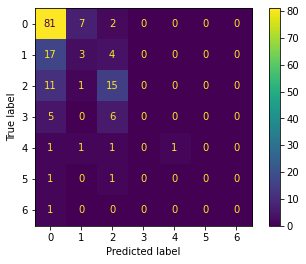

In [52]:
print("balanced_accuracy: ",balanced_accuracy_score(y_val, LogisticRegression_predictions))
print("accuracy: ",accuracy_score(y_val, LogisticRegression_predictions))
print("precision: ",precision_score(y_val, LogisticRegression_predictions,average='weighted'))
print("recall: ",recall_score(y_val, LogisticRegression_predictions,average='weighted'))
print("f1 score: ",f1_score(y_val, LogisticRegression_predictions,average='weighted'))

cm = confusion_matrix(y_val, LogisticRegression_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [72]:
len(y_val)

159

In [53]:
mean_iou_calculator(y_val, LogisticRegression_predictions, "time")

,mean_iou,iou_(1),iou_(2),iou_(3),iou_(4),iou_(5),iou_(6),iou_(7)
0,0.261508,0.9,0.125,0.555556,0.0,0.25,0.0,0.0


#### RandomForestClassifier

balanced_accuracy:  0.24235209235209235
accuracy:  0.4528301886792453
precision:  0.6322004092293476
recall:  0.4528301886792453
f1 score:  0.5000852897899657


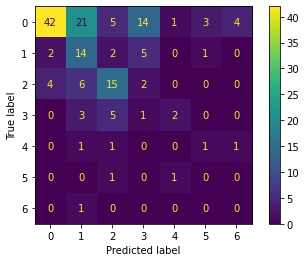

In [54]:
print("balanced_accuracy: ",balanced_accuracy_score(y_val, rndmForest_predictions))
print("accuracy: ",accuracy_score(y_val, rndmForest_predictions))
print("precision: ",precision_score(y_val, rndmForest_predictions,average='weighted'))
print("recall: ",recall_score(y_val, rndmForest_predictions,average='weighted'))
print("f1 score: ",f1_score(y_val, rndmForest_predictions,average='weighted'))

cm = confusion_matrix(y_val, rndmForest_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [55]:
mean_iou_calculator(y_val, rndmForest_predictions, "time")

,mean_iou,iou_(1),iou_(2),iou_(3),iou_(4),iou_(5),iou_(6),iou_(7)
0,0.242352,0.466667,0.583333,0.555556,0.090909,0.0,0.0,0.0


#### KNeighborsClassifier

balanced_accuracy:  0.17724867724867724
accuracy:  0.5849056603773585
precision:  0.43423180592991917
recall:  0.5849056603773585
f1 score:  0.48306574475565445


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


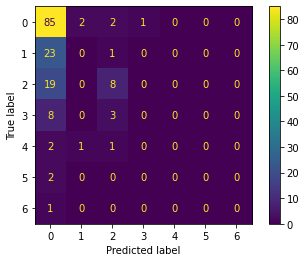

In [56]:
print("balanced_accuracy: ",balanced_accuracy_score(y_val, KNeighbors_predictions))
print("accuracy: ",accuracy_score(y_val, KNeighbors_predictions))
print("precision: ",precision_score(y_val, KNeighbors_predictions,average='weighted'))
print("recall: ",recall_score(y_val, KNeighbors_predictions,average='weighted'))
print("f1 score: ",f1_score(y_val, KNeighbors_predictions,average='weighted'))

cm = confusion_matrix(y_val, KNeighbors_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [57]:
mean_iou_calculator(y_val, KNeighbors_predictions, "time")

,mean_iou,iou_(1),iou_(2),iou_(3),iou_(4),iou_(5),iou_(6),iou_(7)
0,0.177249,0.944444,0.0,0.296296,0.0,0.0,0.0,0.0


#### CSupportVector

balanced_accuracy:  0.19523809523809524
accuracy:  0.5974842767295597
precision:  0.44723180682451513
recall:  0.5974842767295597
f1 score:  0.5066780500298813


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


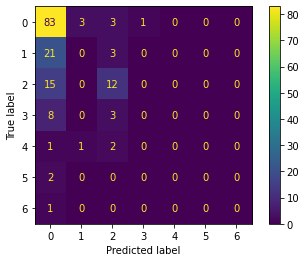

In [58]:
print("balanced_accuracy: ",balanced_accuracy_score(y_val, CSupportVector_predictions))
print("accuracy: ",accuracy_score(y_val, CSupportVector_predictions))
print("precision: ",precision_score(y_val, CSupportVector_predictions,average='weighted'))
print("recall: ",recall_score(y_val, CSupportVector_predictions,average='weighted'))
print("f1 score: ",f1_score(y_val, CSupportVector_predictions,average='weighted'))

cm = confusion_matrix(y_val, CSupportVector_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [59]:
mean_iou_calculator(y_val, CSupportVector_predictions, "time")

,mean_iou,iou_(1),iou_(2),iou_(3),iou_(4),iou_(5),iou_(6),iou_(7)
0,0.195238,0.922222,0.0,0.444444,0.0,0.0,0.0,0.0


# Take input and create df_inp 

In [60]:
def is_prod_in_data(df):
    prods = df["product"].unique()
    prd = str(input("Product seç: "))
    if prd not in prods: 
        return False, prd
    else:
        return True, prd
    
def is_prod_in_data_drop(df, prd):
    prods = df["product"].unique()
    if prd not in prods: 
        return False
    else:
        return True

In [79]:
def take_input(df, prd):
    amo = input("Amount: ") 
    y = False
    while y == False:
        if (amo.isnumeric() == False):
            print("Pozitif tam sayı değer giriniz")
            amo = input("Amount: ")

        else:
            d = max(df[df["product"] == prd]["amount"].to_list()) * 3
            if int(amo) > d:
                print("Amount yüksek abi emin misin bak !?")
                y_n = input("y / n ?")
                if y_n == "y":
                    y = True
                elif y_n == "n":
                    amo = input("Amount: ")                   
            else:
                y = True
    amo = int(amo)

    w_days = ['pts', 'sal', 'çrş', 'prş', 'cum', 'cts', 'paz']
    wd = str(input("Week day: "))
    z = False
    while z == False:
        if wd not in w_days:
            print("Geçerli gün giriniz...")
            print("Geçerli günler: ", w_days)
            wd = str(input("Week day: "))
        else:
            z = True

    typ = df[df["product"] == prd]["type"].unique()[0] 
    comps = df[df["product"] == prd]["company"].unique()
    tws = df[df["product"] == prd]["town"].unique()

    df_inp = pd.DataFrame(columns = ['product', 'company', 'amount', 'town', 'type', 'week day'])

    for comp in comps:
        tw = df[(df["product"] == prd) & (df["company"] == comp)]["town"].unique()[0]

        df_inp = df_inp.append({'product' : prd, 'company' : comp, 'amount' : amo, 'town' : tw,'type' : typ,
                            'week day' : wd}, ignore_index=True)

    return df_inp, comps

# Take Input !!!!!!!!!!!!

In [105]:
def run():
    #c = True
    cond1 = False ###
    #while c:
    while cond1 == False: ###
        tf, prd = is_prod_in_data(data_clean)
        
        if tf:
            df_inp, comps = take_input(data_clean, prd)
            c = False
            cond1 = True
        else:
            if (is_prod_in_data_drop(drop_df, prd) == True):
                print("Güvenilir sonuç için product'a ait en az 5 giriş bulunmalıdır.")
                print("\n","Daha önce bu product alımları: ")
                a = drop_df[drop_df["product"] == prd]
                a = a.index.to_list()
                a = data.loc[a]
                df_inp = display(a[['company', 'amount', 'town', 'order date', 'delivery date', 'time']].style.hide_index())
                print ("Ortalama miktar = ", a["amount"].mean(), "Ortalama süre = ", a["time"].mean())
                return df_inp, cond1
    
            else:
                df_inp = print("Product bulunamadı.")
    if cond1:
        df_inp  = one_hot(df_inp, "week day")
        df_inp  = one_hot(df_inp, "product")
        df_inp  = one_hot(df_inp, "company")

        df_inp = df_inp.drop('town',axis = 1).reset_index(drop=True)

        df_inp["amount"] = (df_inp["amount"] - xt_min) / (xt_max - xt_min)

        df_inp = df_empty.append(df_inp)
        df_inp = df_inp.fillna(0)

        df_inp = pca.transform(df_inp)
        
    return df_inp, cond1
        

In [103]:
drop_df

,product,company,amount,town,type,week day,time
1,K669,T-016,1,istanbul,1,cum,4
2,K75,T-018,1,istanbul,1,çrş,1
3,K669,T-016,1,istanbul,1,pts,1
4,K513,T-034,1,istanbul,1,sal,1
9,K637,T-015,1,istanbul,1,cum,7
...,...,...,...,...,...,...,...
1108,K788,T-060,960,tekirdağ,1,sal,1
1109,K788,T-060,960,tekirdağ,1,prş,1
1110,K730,T-0142,960,missing,1,prş,1
1114,K1117,T-0211,960,kocaeli,1,sal,1


In [101]:
data_clean[data_clean["product"]=="K744"]

,product,company,amount,town,type,week day,time
360,K744,T-0108,10,istanbul,1,cum,10
362,K744,T-0108,10,istanbul,1,çrş,36
374,K744,T-0108,20,istanbul,1,pts,11


In [107]:
df_inp, cond1 = run()

Product seç: K744
Amount: 5
Week day: sal
one hot encoding  week day ...
week day encoded.
one hot encoding  product ...
product encoded.
one hot encoding  company ...
company encoded.


In [ ]:
#data_clean[data_clean["product"] == "30.02.11.0064"]

In [ ]:
#drop_df[drop_df["product"] == "30.02.11.0064"]

In [ ]:
# if cond1:
#     display(df_inp) 

# Input data pre-processing

In [ ]:
# def preprocess(df_inp, cond1)
#     if cond1:
#         df_inp  = one_hot(df_inp, "week day")
#         df_inp  = one_hot(df_inp, "product")
#         df_inp  = one_hot(df_inp, "company")

#         df_inp = df_inp.drop('town',axis = 1).reset_index(drop=True)

#         df_inp["amount"] = (df_inp["amount"] - xt_min) / (xt_max - xt_min)

#         df_inp = df_empty.append(df_inp)
#         df_inp = df_inp.fillna(0)

#         df_inp = pca.transform(df_inp)

# Predict

#### LogisticRegression

In [108]:
if cond1:
    LR = Logistic_Regression.predict(df_inp)
    print(LR)

[1]


#### RandomForest

In [109]:
if cond1:
    RF = rndmForest.predict(df_inp)
    print(RF)

[1]


#### KNeighbors

In [110]:
if cond1:
    KN = KNeighbors.predict(df_inp)
    print(KN)

[1]


#### CSupportVector

In [111]:
if cond1:
    CSV = CSupportVector.predict(df_inp)
    print(CSV)

[1]


## Collective Result

In [ ]:
if cond1:
    res = np.array([])
    output = np.array([])
    for i in range(len(LR)):
        res = np.append(res, [LR[i], RF[i], KN[i], CSV[i]])
        m = mode(res)[0][0]
        output = np.append(output, m)
        res = np.array([])
    output

In [ ]:
if cond1:
    for i in range(len(output)):
        print("for company ", comps[i], ", time = ", output[i])

In [ ]:
df_inp = 0
del(df_inp)

# AUPRC ??